
# Trader Behavior vs Market Sentiment (Fear/Greed) — EDA


In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

csv_dir = "csv_files"
out_dir = "outputs"
os.makedirs(csv_dir, exist_ok=True)
os.makedirs(out_dir, exist_ok=True)

fg =  pd.read_csv("fear_greed_index.csv")
hist = pd.read_csv("historical_data.csv")

hist["Timestamp_parsed"] = pd.to_datetime(hist["Timestamp IST"], errors="coerce")
hist["Date"] = hist["Timestamp_parsed"].dt.date

hist["ClosedPnL"] = pd.to_numeric(hist["Closed PnL"], errors="coerce")
hist["SizeUSD"] = pd.to_numeric(hist["Size USD"], errors="coerce")

daily = hist.groupby("Date").agg({
    "ClosedPnL": ["sum", "mean", "median", "count"],
    "SizeUSD": ["sum", "mean", "median"],
    "Account": "nunique"
})
daily.columns = ["_".join(col).strip() for col in daily.columns.values]
daily = daily.reset_index()

daily = daily.rename(columns={
    "ClosedPnL_sum": "TotalPnL",
    "ClosedPnL_mean": "AvgPnL",
    "ClosedPnL_median": "MedianPnL",
    "ClosedPnL_count": "TradeCount",
    "SizeUSD_sum": "TotalVolumeUSD",
    "SizeUSD_mean": "AvgVolumeUSD",
    "Account_nunique": "ActiveTraders"
})

fg["date"] = pd.to_datetime(fg["date"], errors="coerce").dt.date
fg["classification"] = fg["classification"].astype(str).str.title()

fg = fg.rename(columns={
    "date": "Date",
    "classification": "Classification",
    "value": "SentimentValue"
})

merged = pd.merge(daily, fg[["Date", "Classification", "SentimentValue"]], on="Date", how="left")

size_col = "size" if "size" in hist.columns else None
price_col = None
for c in hist.columns:
    if c.lower().replace(" ", "") in ("executionprice", "price", "avgprice", "fillprice"):
        price_col = c
        break

if size_col and price_col:
    hist["notional_usd"] = pd.to_numeric(hist[size_col], errors="coerce") * pd.to_numeric(hist[price_col], errors="coerce")
elif size_col:
    hist["notional_usd"] = pd.to_numeric(hist[size_col], errors="coerce")
else:
    hist["notional_usd"] = np.nan

pnl_col = None
for c in hist.columns:
    if c.lower() in ("closedpnl", "pnl", "realizedpnl", "realized_pnl", "closed_pnl"):
        pnl_col = c
        break
hist["closedPnL_numeric"] = pd.to_numeric(hist.get(pnl_col, np.nan), errors="coerce")

lev_col = "leverage" if "leverage" in hist.columns else None
hist["leverage_numeric"] = pd.to_numeric(hist.get(lev_col, np.nan), errors="coerce")

acct_col = "account" if "account" in hist.columns else None

agg_dict = {
    "closedPnL_numeric": ["sum", "mean", "median", "count"],
    "notional_usd": ["sum", "mean", "median"]
}
if "leverage_numeric" in hist.columns:
    agg_dict["leverage_numeric"] = ["mean", "median"]

daily = hist.groupby("Date").agg(agg_dict)
daily.columns = ["_".join(col).strip() for col in daily.columns.values]
daily = daily.reset_index()

if acct_col:
    active_traders = hist.groupby("Date")[acct_col].nunique().reset_index(name="ActiveTraders")
    daily = daily.merge(active_traders, on="Date", how="left")
else:
    daily["ActiveTraders"] = np.nan

daily = daily.rename(columns={
    "closedPnL_numeric_sum": "TotalPnL",
    "closedPnL_numeric_mean": "AvgPnL",
    "notional_usd_sum": "TotalNotionalUSD",
    "notional_usd_mean": "AvgNotionalUSD",
    "leverage_numeric_mean": "AvgLeverage"
})

merged = pd.merge(daily, fg[["Date", "Classification"]], on="Date", how="left")

merged.to_csv(os.path.join(csv_dir, "merged_daily_metrics.csv"), index=False)

merged.head()


,Date,TotalPnL,AvgPnL,closedPnL_numeric_median,closedPnL_numeric_count,TotalNotionalUSD,AvgNotionalUSD,notional_usd_median,AvgLeverage,leverage_numeric_median,ActiveTraders,Classification
0,2023-01-05,0.000000,0.000000,0.00000,3,0.0,NaN,NaN,NaN,NaN,NaN,Fear
1,2023-05-12,0.000000,0.000000,0.00000,9,0.0,NaN,NaN,NaN,NaN,NaN,Neutral
2,2024-01-01,-129.531460,-7.196192,0.00000,18,0.0,NaN,NaN,NaN,NaN,NaN,Greed
3,2024-01-02,0.000000,0.000000,0.00000,6,0.0,NaN,NaN,NaN,NaN,NaN,Greed
4,2024-01-03,8244.241409,60.176945,27.04384,137,0.0,NaN,NaN,NaN,NaN,NaN,Greed


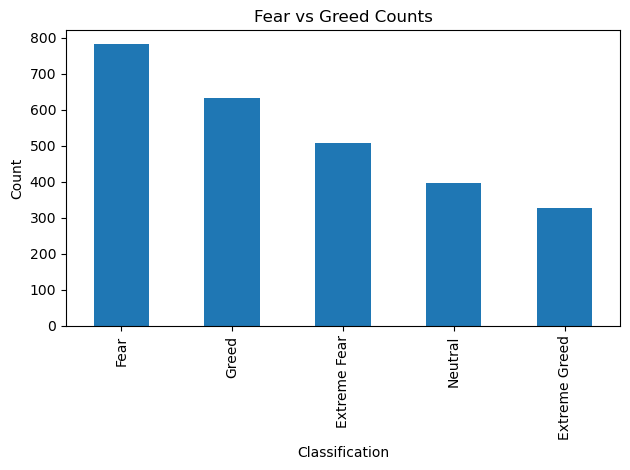

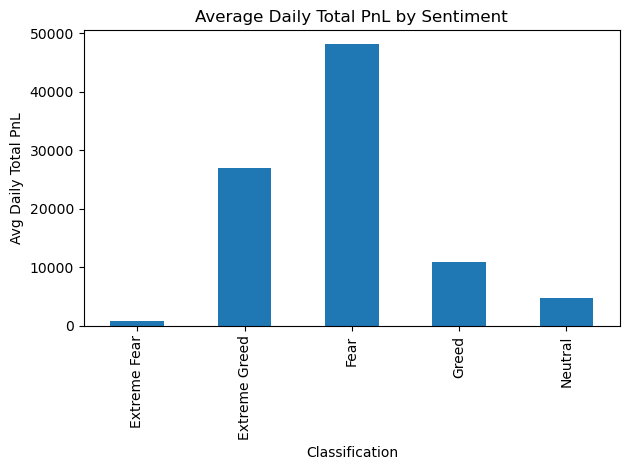

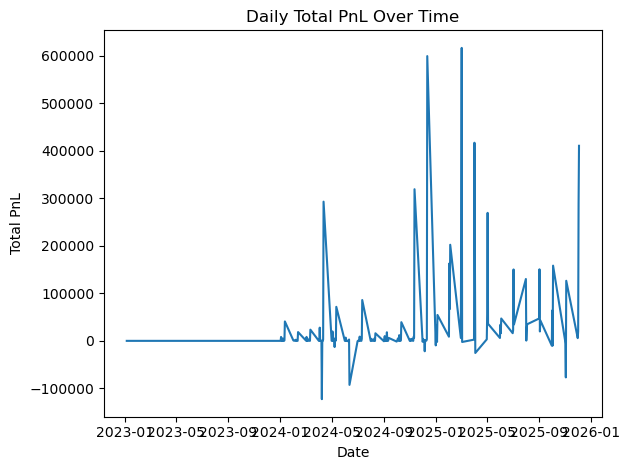

In [13]:
if "Classification" in fg.columns:
    plt.figure()
    fg["Classification"].value_counts().plot(kind="bar")
    plt.title("Fear vs Greed Counts")
    plt.xlabel("Classification")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "classification_count.png"), dpi=200)
    plt.show()

if "Classification" in merged.columns and "TotalPnL" in merged.columns:
    plt.figure()
    merged.groupby("Classification")["TotalPnL"].mean().dropna().plot(kind="bar")
    plt.title("Average Daily Total PnL by Sentiment")
    plt.xlabel("Classification")
    plt.ylabel("Avg Daily Total PnL")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "pnl_by_classification.png"), dpi=200)
    plt.show()

if "Classification" in merged.columns and "AvgLeverage" in merged.columns:
    data_to_plot, labels = [], []
    for cls, sub in merged.groupby("Classification"):
        vals = sub["AvgLeverage"].dropna().values
        if len(vals) > 0:
            data_to_plot.append(vals)
            labels.append(str(cls))
    if len(data_to_plot) > 0:
        plt.figure()
        plt.boxplot(data_to_plot, labels=labels, showmeans=True)
        plt.title("Avg Daily Leverage by Sentiment")
        plt.xlabel("Classification")
        plt.ylabel("Average Leverage")
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, "leverage_by_classification.png"), dpi=200)
        plt.show()

if "TotalPnL" in merged.columns:
    plt.figure()
    merged_sorted = merged.sort_values("Date")
    plt.plot(pd.to_datetime(merged_sorted["Date"]), merged_sorted["TotalPnL"])
    plt.title("Daily Total PnL Over Time")
    plt.xlabel("Date")
    plt.ylabel("Total PnL")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "timeseries_totalpnl.png"), dpi=200)
    plt.show()
